# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

## Если вы выбрали pix2pix
---------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для pix2pix модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все безплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Если вы выбрали CycleGAN
--------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для CycleGAN модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. CycleGAN в этом смысле хуже, чем pix2pix, он ест больше памяти. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все беcплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Remarks:
-----------------------------------------

* Это задание нужно для того, чтобы вы наступили на все грабли, что есть. Узнали об их существовании и научились обходить. Посмотрели на неработающие модели и поняли, что все тлен. Изгуглили весь интернет и в конце заставили это все работать. Поверьте, оно того стиот. Не откладывайте это задание на ночь перед сдачей, так как весь смысл \*пуф\* улетучится.

* У вас два союзника в этой борьбе:
    1. Оригинальная статья, те психи, что ее писала как то заставили свою модель работать. Их мысли, которыми они спроводили свое детище, позволят вам написать свой вариант алгоритма. 
    2. Гугл, он знает ответы на почти все ваши вопросы, но у него есть две ипостаси одна простая в обещении и вы все ее занаете(русскоязычная), а есть еще одна, которая кусается, но знает больше(англоязычная). Если не знаете языва - учите на ходу :)
    
* На самом деле у вас есть еще один союзник, это ментор проекта(или лектор или семинарист). Его ресурсом нужно пользоваться в ситуации, в которой вы не можете(занчит попытались и не вышло) найти ответов, используя Гугл и статью.

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

In [1]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

from IPython.display import clear_output

In [2]:
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
cnn = models.vgg19(pretrained=True).features.to(device).eval().requires_grad_(False)

In [5]:
# replace maxpools with avgpool

for (i, layer) in enumerate(cnn):
    if isinstance(layer, torch.nn.MaxPool2d):
        cnn[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

# Helper functions

In [6]:
def im_convert(tensor):
    
    # convert tesnor to image, denormalize
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [70]:
def load_image(img_path, max_size=256, shape=None):
    
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the alpha channel (that's the :3) and add the batch dimension
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [71]:
def get_features(image, model, layers=None):
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # content layer
                  '28': 'conv5_1'}
    
    features = {}
    x = image
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [72]:
def gram_matrix(tensor):

    batch_size, channels, height, width = tensor.size()
    
    tensor = tensor.view(batch_size * channels, height * width)
    
    gram = tensor @ tensor.t()
    
    return gram 

# Load images

In [73]:
# load content
content = load_image('bruges.jpg').to(device)
# load styles, resize style to content
style_1 = load_image('egon_schiele.jpg', shape=content.shape[-2:]).to(device)
style_2 = load_image('starry_night.jpg', shape=content.shape[-2:]).to(device)
# load mask, do not normalize and resize mask, sicne we will resize and binarize it later anyway
mask_img = Image.open('bruges_mask.jpg').convert('RGB')

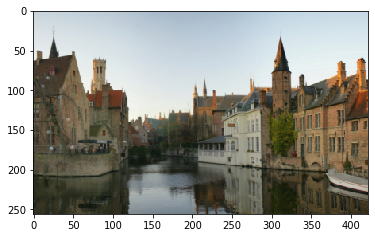

In [74]:
plt.imshow(im_convert(content))

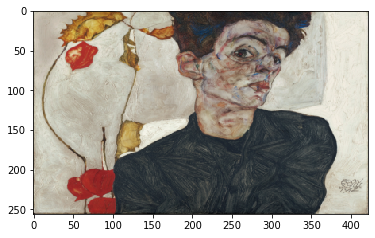

In [75]:
plt.imshow(im_convert(style_1))

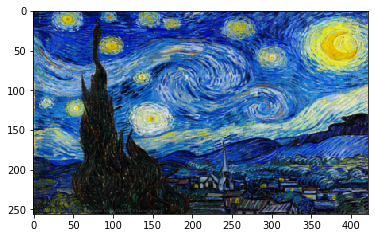

In [76]:
plt.imshow(im_convert(style_2))

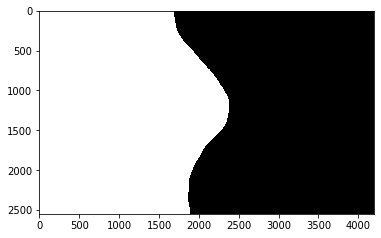

In [77]:
plt.imshow(np.asarray(mask_img))

In [78]:
content_features = get_features(content, cnn)
style_1_features = get_features(style_1, cnn)
style_2_features = get_features(style_2, cnn)

In [79]:
style_1_grams = {layer: gram_matrix(style_1_features[layer]) for layer in style_1_features}
style_2_grams = {layer: gram_matrix(style_2_features[layer]) for layer in style_2_features}

In [80]:
target = content.clone().requires_grad_(True).to(device)

In [81]:
style_1_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

style_2_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1 
style_1_weight = 1e9
style_2_weight = 1e9

# Две части картинки - два стиля

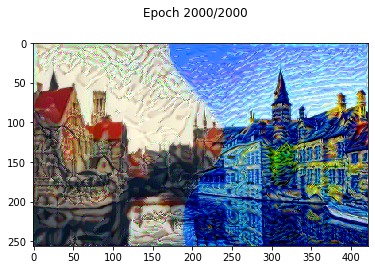

In [82]:
show_every = 50
optimizer = optim.Adam([target], lr=3e-3)
num_epochs = 2000 
mask_transform = lambda size: transforms.Compose([transforms.Resize(size), transforms.ToTensor(),])
resized_masks = None

for ii in range(1, num_epochs+1):
    
    target_features = get_features(target, cnn)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_1_loss = 0
    style_2_loss = 0
        
    
    if resized_masks is None:
        resized_masks = {key:mask_transform(target_features[key].shape[2:4])(mask_img)[0].unsqueeze(0).unsqueeze(1).to(device)>0 for key in target_features}
    
    for layer in style_1_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        mask = resized_masks[layer]
        
        target_1_gram = gram_matrix(target_feature*mask)
        target_2_gram = gram_matrix(target_feature*(~mask))
        
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_1_gram = style_1_grams[layer]
        style_2_gram = style_2_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_1_loss = style_1_weights[layer] * torch.mean((target_1_gram - style_1_gram)**2)
        layer_style_2_loss = style_2_weights[layer] * torch.mean((target_2_gram - style_2_gram)**2)
        # add to the style loss
        style_1_loss += layer_style_1_loss / (d * h * w)
        style_2_loss += layer_style_2_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_1_weight * style_1_loss + style_2_weight * style_2_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        clear_output()
        plt.imshow(im_convert(target))
        plt.suptitle('Epoch %d/%d'%(ii, num_epochs))
        plt.show()

# Одна картинка - два стиля

In [83]:
# reinit
target = content.clone().requires_grad_(True).to(device)

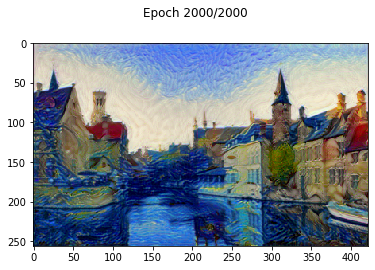

In [84]:
show_every = 50
optimizer = optim.Adam([target], lr=3e-3)
num_epochs = 2000 

for ii in range(1, num_epochs+1):
    
    target_features = get_features(target, cnn)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_1_loss = 0
    style_2_loss = 0
        
    mask_transform = lambda size: transforms.Compose([transforms.Resize(size), transforms.ToTensor(),])
    resized_masks = {key:mask_transform(target_features[key].shape[2:4])(mask_img)[0].unsqueeze(0).unsqueeze(1).to(device)>0 for key in target_features}
    
    for layer in style_1_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        
        target_gram = gram_matrix(target_feature)
        
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_1_gram = style_1_grams[layer]
        style_2_gram = style_2_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_1_loss = style_1_weights[layer] * torch.mean((target_gram - style_1_gram)**2)
        layer_style_2_loss = style_2_weights[layer] * torch.mean((target_gram - style_2_gram)**2)
        # add to the style loss
        style_1_loss += layer_style_1_loss / (d * h * w)
        style_2_loss += layer_style_2_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_1_weight * style_1_loss + style_2_weight * style_2_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        clear_output()
        plt.imshow(im_convert(target))
        plt.suptitle('Epoch %d/%d'%(ii, num_epochs))
        plt.show()